# Debug IonBeam Sources
The purpose of this notebook is to debug a particular source by running various components of its functionality and printing it. Input the target source below and it will be selected from the config.

In [1]:
# source_to_debug = "meteotracker"
source_to_debug = "smart_citizen_kit"
# source_to_debug = "acronet"

offline = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# !pip install wurlitzer

In [4]:
%load_ext wurlitzer

In [5]:
import pandas as pd
import numpy as np
import logging
import pyfdb
import findlibs
import yaml
from pathlib import Path
import os
import pandas as pd
import pyodc
import shutil
from pathlib import Path
from ionbeam.core.config_parser import parse_config
from ionbeam.core.bases import *
from IPython.display import display
from matplotlib import pyplot as plt
from ionbeam.metadata.db import init_db

In [6]:
logging.basicConfig(level = logging.INFO)
logging.getLogger('matplotlib').setLevel(level = logging.WARNING)

print("Parsing config...")
config_file = Path("~/git/IonBeam-Deployment/config/ionbeam").expanduser()
config, actions = parse_config(config_file,
                    config_path = "./",
                    data_path = "../data/",
                    offline = offline,
                    environment  = "local",
                    sources = [source_to_debug]
                    )

if config.globals.environment == "local": 
    print("Wiping and initialising local database...")
    init_db(config.globals)

source = [a for a in actions if isinstance(a, Source)][0]

Parsing config...
Wiping and initialising local database...


INFO:ionbeam.metadata.db:Adding 'Sensor.Community' to Authors table
INFO:ionbeam.metadata.db:Adding 'Meteotracker' to Authors table
INFO:ionbeam.metadata.db:Adding 'Acronet' to Authors table
INFO:ionbeam.metadata.db:Adding 'SmartCitizenKit' to Authors table


In [7]:
source

id,33440e2b-e098-48a2-8071-47049e3d6513
mappings,"[InputColumn(name='time', key='time', type=None, unit=None, discard=False, canonical_variable=Non..."
finish_after,None
copy_metadata_to_columns,"[sensor_name, lat, lon, created_at, city, country, author]"
cache_version,2
use_cache,True
cache_directory,/Users/math/git/IonBeam-Deployment/data/inputs/smart_citizen_kit
name,value
source_action_id,33440e2b-e098-48a2-8071-47049e3d6513
state,raw
mars_request,{}


## Show the connection structure of the actions defined in the config

In [8]:
from ionbeam.core.config_parser import print_action_chains
print_action_chains(actions)

SmartCitizenKitSource --> CSVParser --> Splitter --> TimeAggregator --> ODCEncoder
[Match(state = 'odc_encoded')] --> RESTWriter()


## Show the raw data keys that are being extracted from the raw api data and which canonical variables they are mapped to

In [9]:
print("Source copies these external keys to these canonical variables:")
import pandas as pd
cvs = {c.name : c for c in config.globals.canonical_variables}
pd.DataFrame.from_records((dict(
                               source_key = c.key, source_unit = c.unit, 
                               discard = c.discard,
                               canonical_name = c.name if not c.discard else "",
                               canonical_unit = cvs[c.name].unit if not c.discard else "",
                                ) for c in source.mappings))

Source copies these external keys to these canonical variables:


,source_key,source_unit,discard,canonical_name,canonical_unit
0,time,None,False,time,None
1,sensor.name,None,False,sensor_name,None
2,device.name,None,False,author,None
3,device.location.latitude,EPSG:4326,False,lat,EPSG:4326
4,device.location.longitude,EPSG:4326,False,lon,EPSG:4326
...,...,...,...,...,...
62,adc_48_3,V,True,,
63,adc_49_0,V,True,,
64,adc_49_1,V,True,,
65,adc_49_2,V,True,,


## Get source chunks for the last seven days

In [10]:
from datetime import datetime, timedelta, timezone
import itertools as it

now = datetime.now(tz=timezone.utc)
earlier = now - timedelta(days = 7)

chunk_iterable = source.get_chunks(earlier, now)
chunks = list(it.islice(chunk_iterable, 5))
chunks[0].keys()

dict_keys(['key', 'device_id', 'sensor_id', 'start_date', 'end_date', 'device', 'sensor'])

## Download one of those chunks

In [11]:
raw_messages = list(source.download_chunk(chunks[0]))
print(f"{len(raw_messages) = }")

len(raw_messages) = 1


## Use the actual interface so that extra steps like copying metadata over get done

In [12]:
raw_messages = list(it.islice(source.generate(), 50))
len(raw_messages)

50

## Check the metadata that got loaded in by this

In [13]:
import json
from sqlalchemy.orm import Session
from ionbeam.metadata import db

with Session(config.globals.sql_engine) as session:
    stations = session.query(db.Station).all()
    for s in stations:
        s = s.as_json()
        del s["geojson"]
        for k in ["name", "description", "external_id"]:
            print(f"{k}: {s[k]}")
        print(f"Properties: {[p['name'] for p in s['sensors'][0]['properties']]}")
        print()

name: I-CHANGE CIMA ARENZANO
description: Smart Citizen Kit 2.1 with Urban Sensor Board
external_id: 16517
Properties: ['total_volatile_organic_compounds', 'equivalent_carbon_dioxide']



## Pass a message through the CSVParser

In [14]:
from IPython.display import display

def display_columns(cols):
    display(pd.DataFrame.from_records((dict(key = c.key,  
                               discard = c.discard,
                               name = c.name if not c.discard else "", 
                                source_unit = c.unit,
                               unit = cvs[c.name].unit if not c.discard else "", ) for c in cols), index = "name"))


csv_parser = [a for a in actions if isinstance(a, Parser)][0]
print("Columns that will be present in all output because they represent metadata")
display_columns(csv_parser.fixed_columns)

print("\n\nData Columns")
display_columns(csv_parser.value_columns)

Columns that will be present in all output because they represent metadata


,key,discard,source_unit,unit
name,,,,
time,time,False,None,None
sensor_name,sensor.name,False,None,None
author,device.name,False,None,None
lat,device.location.latitude,False,EPSG:4326,EPSG:4326
lon,device.location.longitude,False,EPSG:4326,EPSG:4326
created_at,device.created_at,False,None,None
city,device.location.city,False,None,None
country,device.location.country,False,None,None




Data Columns


,key,discard,source_unit,unit
name,,,,
total_volatile_organic_compounds,TVOC,False,ppb,ppb
total_volatile_organic_compounds,tvoc,False,ppb,ppb
equivalent_carbon_dioxide,eco2,False,ppm,ppm
equivalent_carbon_dioxide,eCO2,False,ppm,ppm
ambient_light,Light,False,lux,lux
ambient_light,light,False,lux,lux
noise_dB,Noise Level,False,dB,dB
noise_dBA,Noise Level,False,dBA,dBA
noise_dBA,noise_dba,False,dBA,dBA


In [15]:
raw_messages[0].data

,time,tvoc,sensor_name,lat,lon,created_at,city,country,author
0,2024-07-18T09:49:34Z,0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30T18:40:26Z,Savona,Italy,I-CHANGE CIMA SAVONA
1,2024-07-18T09:48:34Z,0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30T18:40:26Z,Savona,Italy,I-CHANGE CIMA SAVONA
2,2024-07-18T09:46:15Z,0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30T18:40:26Z,Savona,Italy,I-CHANGE CIMA SAVONA
3,2024-07-18T09:45:15Z,1,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30T18:40:26Z,Savona,Italy,I-CHANGE CIMA SAVONA
4,2024-07-18T09:44:15Z,0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30T18:40:26Z,Savona,Italy,I-CHANGE CIMA SAVONA
...,...,...,...,...,...,...,...,...,...
9588,2024-07-11T09:56:58Z,0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30T18:40:26Z,Savona,Italy,I-CHANGE CIMA SAVONA
9589,2024-07-11T09:55:58Z,1,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30T18:40:26Z,Savona,Italy,I-CHANGE CIMA SAVONA
9590,2024-07-11T09:54:58Z,4,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30T18:40:26Z,Savona,Italy,I-CHANGE CIMA SAVONA
9591,2024-07-11T09:53:58Z,0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30T18:40:26Z,Savona,Italy,I-CHANGE CIMA SAVONA


In [16]:
csv_parser.columns_mapping

{'time': 'time',
 'sensor.name': 'sensor_name',
 'device.name': 'author',
 'device.location.latitude': 'lat',
 'device.location.longitude': 'lon',
 'device.created_at': 'created_at',
 'device.location.city': 'city',
 'device.location.country': 'country',
 'TVOC': 'total_volatile_organic_compounds',
 'tvoc': 'total_volatile_organic_compounds',
 'eco2': 'equivalent_carbon_dioxide',
 'eCO2': 'equivalent_carbon_dioxide',
 'Light': 'ambient_light',
 'light': 'ambient_light',
 'Noise Level': 'noise_dBA',
 'noise_dba': 'noise_dBA',
 'Barometric Pressure': 'air_pressure_near_surface',
 'bar': 'air_pressure_near_surface',
 'NO2': 'nitrogen_oxide',
 'no2': 'nitrogen_oxide',
 'PM 1': 'particulate_matter_1',
 'pm_avg_1': 'particulate_matter_1',
 'PM 10': 'particulate_matter_10',
 'pm_avg_10': 'particulate_matter_10',
 'PM 2.5': 'particulate_matter_2_5',
 'pm_avg_2.5': 'particulate_matter_2_5',
 'PN0.3': 'particulate_matter_particle_number_0_3',
 'PN0.5': 'particulate_matter_particle_number_0_5',
 

In [17]:
df = csv_parser.format_dataframe(raw_messages[0].data)
df

,time,total_volatile_organic_compounds,sensor_name,lat,lon,created_at,city,country,author
0,2024-07-18 09:49:34+00:00,0.0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30 18:40:26+00:00,Savona,Italy,I-CHANGE CIMA SAVONA
1,2024-07-18 09:48:34+00:00,0.0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30 18:40:26+00:00,Savona,Italy,I-CHANGE CIMA SAVONA
2,2024-07-18 09:46:15+00:00,0.0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30 18:40:26+00:00,Savona,Italy,I-CHANGE CIMA SAVONA
3,2024-07-18 09:45:15+00:00,1.0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30 18:40:26+00:00,Savona,Italy,I-CHANGE CIMA SAVONA
4,2024-07-18 09:44:15+00:00,0.0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30 18:40:26+00:00,Savona,Italy,I-CHANGE CIMA SAVONA
...,...,...,...,...,...,...,...,...,...
9588,2024-07-11 09:56:58+00:00,0.0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30 18:40:26+00:00,Savona,Italy,I-CHANGE CIMA SAVONA
9589,2024-07-11 09:55:58+00:00,1.0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30 18:40:26+00:00,Savona,Italy,I-CHANGE CIMA SAVONA
9590,2024-07-11 09:54:58+00:00,4.0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30 18:40:26+00:00,Savona,Italy,I-CHANGE CIMA SAVONA
9591,2024-07-11 09:53:58+00:00,0.0,AMS CCS811 - TVOC,44.2992,8.45138,2023-01-30 18:40:26+00:00,Savona,Italy,I-CHANGE CIMA SAVONA


In [18]:
def pump_through(action, messages):
    return [out_msg
           for in_msg in messages
           for out_msg in action.process(in_msg)]

parsed_messages = pump_through(csv_parser, raw_messages)

AttributeError: 'DataFrame' object has no attribute 'station_id'

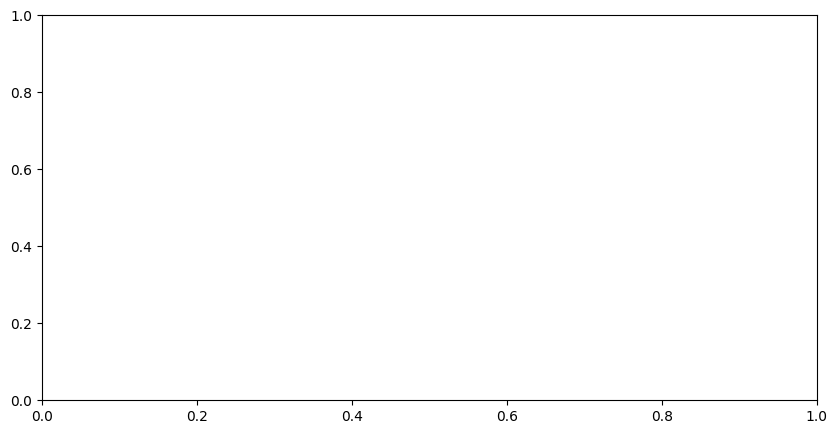

In [19]:

f, ax1 = plt.subplots(figsize = [10,5])
for i, m in enumerate(parsed_messages):
    t = m.data.time
    start, end = m.data.time.min(), m.data.time.max()
    ax1.hlines(y = i, xmin = start, xmax = end, label = m.data.station_id.iloc[0])
    # print(start, end)

ax1.vlines(x = [start, end], ymin = 0, ymax = len(parsed_messages), linestyle = "dotted", color = "k")
ax1.legend()

In [ ]:
from ionbeam.aggregators import TimeAggregator
from ionbeam.parsers import Splitter

splitter = [a for a in actions if isinstance(a, Splitter)][0]
time_aggregator = [a for a in actions if isinstance(a, TimeAggregator)][0]

split_messages = pump_through(splitter, parsed_messages)
print(f"{len(split_messages)=}")

In [ ]:
aggregated_messages = pump_through(time_aggregator, split_messages)

# Force the aggregator to dumps its contents even if it's not happy about it 
unhappy_aggregated_messages = list(time_aggregator.process(FinishMessage("We're done!")))

aggregated_messages

In [ ]:
f, ax1 = plt.subplots(figsize = [10,5])
for i, m in enumerate(aggregated_messages):
    t = m.data.time
    start, end = m.data.time.min(), m.data.time.max()
    ax1.hlines(y = i, xmin = start, xmax = end)
    # print(start, end)

for i, m in enumerate(unhappy_aggregated_messages):
    t = m.data.time
    start, end = m.data.time.min(), m.data.time.max()
    ax1.hlines(y = i, xmin = start, xmax = end, color= "red")
    # print(start, end)

ax1.vlines(x = [start, end], ymin = 0, ymax = len(parsed_messages), linestyle = "dotted", color = "k")